In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Analysis of User-defined Metabolite Sets

This notebook demonstrates how PALS can be used to analyse user-defined metabolite sets. Here PALS is used to analyse Molecular Families from GNPS, as well as Mass2Motifs from MS2LDA for differentially expressed metabolite sets.

In [2]:
import os
import sys
import pathlib
import pickle

sys.path.append('..')

In [3]:
import pandas as pd
import zipfile
import seaborn as sns
import matplotlib.patches as mpatches
from IPython.display import display, HTML
from loguru import logger

In [4]:
from pals.feature_extraction import DataSource
from pals.loader import GNPSLoader
from pals.PLAGE import PLAGE
from pals.common import *

2020-05-18 21:36:46.792 | INFO     | pals.reactome:get_neo4j_driver:24 - Created graph database driver for bolt://localhost:7687 (neo4j)


## GNPS Molecular Family Analysis

### Load GNPS results using the loader

The loader is used to retrieve molecular networking results from GNPS and extract the necessary data for PALS analysis. 

Input:
- URL to FBMN GNPS results
- A metadata CSV

Provide the link to your FBMN GNPS experiment results below

In [5]:
database_name = DATABASE_GNPS_MOLECULAR_FAMILY
gnps_url = 'https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=0a8432b5891a48d7ad8459ba4a89969f'

Provide a metadata CSV file describing the sample groups

In [6]:
metadata_file = os.path.join('test_data', 'AGP', 'AG_Plants_extremes_metadata_df.csv')
metadata_df = pd.read_csv(metadata_file)
metadata_df

,sample,group
0,11337_P4_RE11_01_484.mzML,Less than 10
1,13313_P4_RE2_01_474.mzML,Less than 10
2,22510_P3_RG10_01_390.mzML,Less than 10
3,27840_P1_RG3_01_118.mzML,Less than 10
4,28742_P6_RH3_01_699.mzML,Less than 10
...,...,...
81,41935_P1_RG11_01_126.mzML,More than 30
82,42739_P3_RH1_01_395.mzML,More than 30
83,43160_P3_RE11_01_361.mzML,More than 30
84,49025_P6_RA4_01_676.mzML,More than 30


Define case and control groups, and create a comparison.

In [7]:
case = 'More than 30'
control = 'Less than 10'
comp_name = 'more_plants/no_plants'
comparisons = [{'case': case, 'control': control, 'name': comp_name },]
comparisons

[{'case': 'More than 30',
  'control': 'Less than 10',
  'name': 'more_plants/no_plants'}]

Instantiate the loader object, and load the data into a `database` object.

In [8]:
loader = GNPSLoader(database_name, gnps_url, metadata_df, comparisons)
database = loader.load_data()

2020-05-18 21:36:47.084 | INFO     | pals.loader:load_data:165 - Retrieving clustering and quantification information from GNPS
2020-05-18 21:36:47.084 | DEBUG    | pals.loader:load_data:166 - https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=0a8432b5891a48d7ad8459ba4a89969f
2020-05-18 21:36:47.085 | INFO     | pals.loader:_download_gnps:365 - Found GNPS task 0a8432b5891a48d7ad8459ba4a89969f
39.7MiB [00:25, 3.89MiB/s]2020-05-18 21:37:13.050 | DEBUG    | pals.loader:_parse_gnps_molfam:410 - Found cluster info: clusterinfo_summary/cffab31fda574b1f961b8b336a3fc9bd.tsv
2020-05-18 21:37:13.141 | DEBUG    | pals.loader:_parse_gnps_molfam:415 - Found quantification table: quantification_table/quantification_table-00000.csv
40.0MiB [00:25, 1.55MiB/s]


Create data source. For the GNPS database, we get *measurement_df*, *annotation_df* and *experimental_design* parameters from *database* before passing them to the *DataSource* constructor.

In [9]:
measurement_df = database.extra_data['measurement_df']
annotation_df = database.extra_data['annotation_df']
experimental_design = database.extra_data['experimental_design']

In [10]:
measurement_df.head()

,11337_P4_RE11_01_484.mzML,13313_P4_RE2_01_474.mzML,22510_P3_RG10_01_390.mzML,27840_P1_RG3_01_118.mzML,28742_P6_RH3_01_699.mzML,30483_P1_GD1_01_145.mzML,37543_P6_RG2_01_695.mzML,37937_P6_RD2_01_686.mzML,38057_P5_RE1_01_602.mzML,38093_P5_RE5_01_606.mzML,...,41323_P1_RG12_01_127.mzML,41341_P2_RE8_01_224.mzML,41534_P6_RB1_01_677.mzML,41698_P3_RC9_01_329.mzML,41744_P6_RE1_01_688.mzML,41935_P1_RG11_01_126.mzML,42739_P3_RH1_01_395.mzML,43160_P3_RE11_01_361.mzML,49025_P6_RA4_01_676.mzML,5990_P2_RB6_01_175.mzML
peak_id,,,,,,,,,,,,,,,,,,,,,
1,16621.9880,7.116694e+04,6.055347e+05,1095.7485,1.140599e+06,14605.3060,4.579952e+04,1.098218e+06,9.364128e+03,1.653913e+04,...,1715.1885,1.936919e+06,1.551468e+05,8492.3235,2.391372e+05,94469.0770,1.985232e+06,3.165443e+05,291132.561,57110.3940
2,226.5455,1.566927e+04,5.025617e+04,395148.9380,1.934524e+05,142826.9005,4.360585e+02,1.532759e+05,2.788818e+04,1.289885e+04,...,145.8310,4.268199e+05,6.492751e+03,7720.6630,1.263886e+04,480.2375,5.066707e+05,1.663545e+04,20276.257,168.3725
3,992235.6470,1.293665e+06,1.181147e+06,0.0000,9.435760e+05,0.0000,1.147643e+06,9.106171e+05,1.458229e+06,1.350834e+06,...,0.0000,0.000000e+00,1.673888e+06,14355.9335,1.304436e+06,0.0000,1.380754e+06,1.227284e+06,1444913.288,0.0000
4,931484.0325,1.214219e+06,9.357495e+05,0.0000,7.189252e+05,145.0350,7.851636e+05,6.281846e+05,1.044920e+06,9.298224e+05,...,269.6995,0.000000e+00,1.086346e+06,7135.2980,9.033790e+05,694.5275,1.056104e+06,9.832828e+05,1043496.384,433.5000
5,810685.3930,8.649341e+05,4.130054e+05,2470.5085,7.716864e+05,2717.1375,6.570987e+05,4.635221e+05,8.705470e+02,1.174299e+03,...,2350.6205,1.245302e+03,1.519240e+06,709596.0825,1.246027e+06,2860.2950,2.444535e+06,4.618985e+05,1872717.354,3621.1830


In [11]:
annotation_df.head()

,entity_id
peak_id,
2,2
4,4
5,5
6,6
7,7


### Create data source and run PLAGE analysis

Create a PALS data source and run PLAGE analysis.

In [12]:
gnps_ds = DataSource(measurement_df, annotation_df, experimental_design, None, database=database, min_replace=SMALL)

2020-05-18 21:37:14.024 | DEBUG    | pals.feature_extraction:__init__:47 - Using user-provided database
2020-05-18 21:37:14.025 | DEBUG    | pals.feature_extraction:__init__:55 - Mapping pathway to unique ids
2020-05-18 21:37:14.029 | DEBUG    | pals.feature_extraction:__init__:69 - Creating dataset to pathway mapping
2020-05-18 21:37:14.499 | DEBUG    | pals.feature_extraction:__init__:97 - Computing unique id counts


In [13]:
plage = PLAGE(gnps_ds, num_resamples=1000)
pathway_df = plage.get_pathway_df(standardize=True)

2020-05-18 21:37:14.768 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:307 - Setting the zero intensity values in the dataframe
2020-05-18 21:37:14.795 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:309 - 0
2020-05-18 21:37:14.916 | DEBUG    | pals.feature_extraction:standardize_intensity_df:276 - Scaling the data across the sample: zero mean and unit variance
2020-05-18 21:37:15.036 | DEBUG    | pals.PLAGE:get_plage_activity_df:84 - Mean values of the rows in the DF is [-0.  0. -0. ...  0.  0. -0.]
2020-05-18 21:37:15.038 | DEBUG    | pals.PLAGE:get_plage_activity_df:85 - Variance in the rows of the DF is [1. 1. 1. ... 1. 1. 1.]
2020-05-18 21:37:15.733 | DEBUG    | pals.PLAGE:set_up_resample_plage_p_df:96 - Calculating plage p-values with resampling
2020-05-18 21:37:15.734 | DEBUG    | pals.PLAGE:set_up_resample_plage_p_df:103 - Comparison more_plants/no_plants
2020-05-18 21:37:15.735 | DEBUG    | pals.PLAGE:set_up_resample_plage_p_df:111 - Resampling 0/1000
20

In [14]:
p_value_col = '%s p-value' % comp_name
count_col = 'unq_pw_F'
pathway_df.sort_values([p_value_col, count_col], ascending=[True, False], inplace=True)
pathway_df

,pw_name,more_plants/no_plants p-value,unq_pw_F,tot_ds_F,F_coverage,sf,exp_F,Ex_Cov,more_plants/no_plants comb_p
65,Molecular Family #65,0.0,81,81,100.0,1.0,81.0,100.0,NaN
21,Molecular Family #21,0.0,64,64,100.0,1.0,64.0,100.0,NaN
223,Molecular Family #223,0.0,46,46,100.0,1.0,46.0,100.0,NaN
590,Molecular Family #590,0.0,33,33,100.0,1.0,33.0,100.0,NaN
148,Molecular Family #148,0.0,23,23,100.0,1.0,23.0,100.0,NaN
...,...,...,...,...,...,...,...,...,...
1045,Molecular Family #1045,1.0,2,2,100.0,1.0,2.0,100.0,NaN
3400,Molecular Family #3400,1.0,2,2,100.0,1.0,2.0,100.0,NaN
1842,Molecular Family #1842,1.0,2,2,100.0,1.0,2.0,100.0,NaN
3885,Molecular Family #3885,1.0,2,2,100.0,1.0,2.0,100.0,NaN


### Checking results

In [15]:
sns.set()
pd.set_option('display.max_colwidth', None)

In [16]:
# cmap = 'RdBu_r'
# cmap = 'jet'
cmap = 'vlag'

Filter significant molecular families by p-value. 

In [17]:
pval_threshold = 0.05
df = pathway_df[pathway_df[p_value_col] < pval_threshold]
df

,pw_name,more_plants/no_plants p-value,unq_pw_F,tot_ds_F,F_coverage,sf,exp_F,Ex_Cov,more_plants/no_plants comb_p
65,Molecular Family #65,0.000000,81,81,100.0,1.0,81.0,100.0,NaN
21,Molecular Family #21,0.000000,64,64,100.0,1.0,64.0,100.0,NaN
223,Molecular Family #223,0.000000,46,46,100.0,1.0,46.0,100.0,NaN
590,Molecular Family #590,0.000000,33,33,100.0,1.0,33.0,100.0,NaN
148,Molecular Family #148,0.000000,23,23,100.0,1.0,23.0,100.0,NaN
...,...,...,...,...,...,...,...,...,...
116,Molecular Family #116,0.027949,9,9,100.0,1.0,9.0,100.0,NaN
91,Molecular Family #91,0.042836,3,3,100.0,1.0,3.0,100.0,NaN
918,Molecular Family #918,0.046410,2,2,100.0,1.0,2.0,100.0,NaN
2784,Molecular Family #2784,0.048126,2,2,100.0,1.0,2.0,100.0,NaN


Count how many significant molecular families having at least 10 members.

In [18]:
min_members = 10
df[df[count_col] >= min_members].shape

(34, 9)

Plot significant molecular families

In [19]:
all_samples = []
all_groups = []
for group in experimental_design['groups']:
    samples = experimental_design['groups'][group]
    all_samples.extend(samples)
    all_groups.extend([group] * len(samples))

In [20]:
entity_dict = gnps_ds.entity_dict
intensities_df = gnps_ds.standardize_intensity_df()

2020-05-18 21:37:19.076 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:307 - Setting the zero intensity values in the dataframe
2020-05-18 21:37:19.099 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:309 - 0
2020-05-18 21:37:19.163 | DEBUG    | pals.feature_extraction:standardize_intensity_df:276 - Scaling the data across the sample: zero mean and unit variance


Molecular Family #65
Molecular Family #21
Molecular Family #223
Molecular Family #590
Molecular Family #148
pw_name                          Molecular Family #148
more_plants/no_plants p-value                        0
unq_pw_F                                            23
tot_ds_F                                            23
F_coverage                                         100
sf                                                   1
exp_F                                               23
Ex_Cov                                             100
more_plants/no_plants comb_p                       NaN
Name: 148, dtype: object


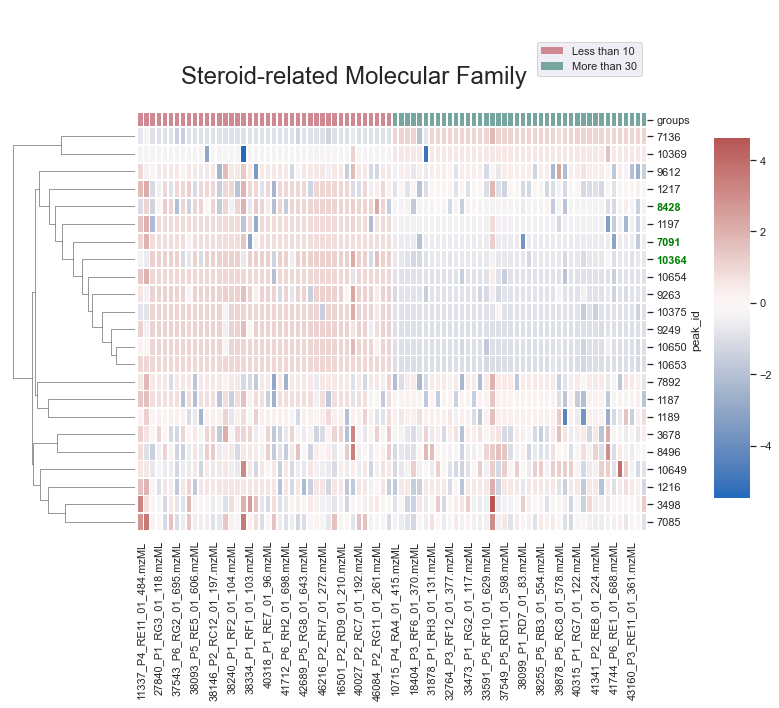

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
1187,NaN,357.2056,3.0498,0.037737,61,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=148&task=0a8432b5891a48d7ad8459ba4a89969f
1189,NaN,385.2352,3.4066,0.005774,85,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=148&task=0a8432b5891a48d7ad8459ba4a89969f
1197,NaN,343.2264,3.6391,0.018462,28,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=148&task=0a8432b5891a48d7ad8459ba4a89969f
1216,NaN,367.2269,3.3133,0.003620,86,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=148&task=0a8432b5891a48d7ad8459ba4a89969f
1217,NaN,339.1964,3.0423,0.003786,109,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=148&task=0a8432b5891a48d7ad8459ba4a89969f
3498,NaN,769.4667,3.3526,0.001045,174,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=148&task=0a8432b5891a48d7ad8459ba4a89969f
3678,NaN,399.3253,5.7595,0.000823,159,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=148&task=0a8432b5891a48d7ad8459ba4a89969f
7085,NaN,713.4052,3.0489,0.003077,176,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=148&task=0a8432b5891a48d7ad8459ba4a89969f
7091,Spectral Match to Mestranol from NIST14,311.2008,3.0540,0.001190,24,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=148&task=0a8432b5891a48d7ad8459ba4a89969f


Molecular Family #54
Molecular Family #215
Molecular Family #528
Molecular Family #192
Molecular Family #279
Molecular Family #321
Molecular Family #817
Molecular Family #234
Molecular Family #107
Molecular Family #27
Molecular Family #1443
Molecular Family #48
Molecular Family #283
Molecular Family #806
Molecular Family #832
Molecular Family #303
Molecular Family #643
Molecular Family #59
Molecular Family #67
Molecular Family #715
Molecular Family #781
Molecular Family #522
Molecular Family #95
Molecular Family #1923
Molecular Family #720
Molecular Family #152
Molecular Family #117
Molecular Family #418
Molecular Family #454


In [21]:
for idx, row in df.iterrows():
    members = gnps_ds.dataset_pathways_to_row_ids[idx]
    if len(members) < min_members:
        continue
        
    pw_name = row['pw_name']
    p_value = row[p_value_col]
    print(pw_name)
    
    # plotting for manuscript
    to_plot = ['Molecular Family #148']
    if pw_name not in to_plot:
        continue
    else:
        print(row)
                
    # get group intensities
    group_intensities = intensities_df.loc[members][all_samples]    
    
    # get group info
    # print('%s p-value=%.4f' % (pw_name, p_value))
    data = []
    for member in members:
        member_info = entity_dict[member]
        unique_id = member_info['unique_id']
        library_id = member_info['LibraryID']
        gnps_linkout_network = member_info['GNPSLinkout_Network']
        no_spectra = member_info['number of spectra']
        rt = member_info['RT']
        mz = member_info['mass']    
        intensity = member_info['SumPeakIntensity']
        row = [unique_id, library_id, mz, rt, intensity, no_spectra, gnps_linkout_network]
        data.append(row)
    member_df = pd.DataFrame(data, columns=['id', 'LibraryID', 'Precursor m/z', 'RTConsensus', 'PrecursorInt', 'no_spectra', 'link']).set_index('id')    
    
    # Create a categorical palette to identify the networks
    used_groups = list(set(all_groups))
    group_pal = sns.husl_palette(len(used_groups), s=.45)
    group_lut = dict(zip(map(str, used_groups), group_pal))

    # Convert the palette to vectors that will be drawn on the side of the matrix
    group_colours = pd.Series(all_groups, index=group_intensities.columns).map(group_lut)    
    group_colours.name = 'groups'
    
    # plot heatmap
    g = sns.clustermap(group_intensities, center=0, cmap=cmap, col_colors=group_colours, 
                   col_cluster=False, linewidths=0.75, figsize=(10, 10), cbar_pos=(1.0, 0.3, 0.05, 0.5))
    
    title = pw_name
    if pw_name == 'Molecular Family #127':
        title = 'Cinnamic Acid-related Molecular Family'
    elif pw_name == 'Molecular Family #148':
        title = 'Steroid-related Molecular Family'
    plt.suptitle('%s' % (title), fontsize=24, y=0.9)

    # draw group legend
    for group in used_groups:
        g.ax_col_dendrogram.bar(0, 0, color=group_lut[group], label=group, linewidth=0)
    g.ax_col_dendrogram.legend(loc="right")
    
    # make the annotated peaks to have labels in bold
    annotated_df = member_df[member_df['LibraryID'].notnull()]
    annotated_peaks = annotated_df.index.values
    for label in g.ax_heatmap.get_yticklabels():
        if label.get_text() in annotated_peaks:
            label.set_weight("bold")
            label.set_color("green")   
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)        

    out_file = '%s.pdf' % pw_name
    plt.savefig(out_file, dpi=300)
    plt.show()
    
    out_file = '%s.csv' % pw_name
    display(member_df)
    member_df.drop('link', axis=1).round(4).to_csv(out_file, index=True)

## GNPS-MS2LDA Analysis

Similar to above, but here we provide a link to GNPS-MS2LDA analysis to retrieve Mass2Motifs, and pass it to the loader.

In [22]:
gnps_ms2lda_url = 'https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=7c34badae00e43bc87b195a706cf1f43'

In [23]:
database_name = DATABASE_GNPS_MS2LDA
loader = GNPSLoader(database_name, gnps_url, metadata_df, comparisons, gnps_ms2lda_url=gnps_ms2lda_url)
database = loader.load_data()

2020-05-18 21:37:20.860 | INFO     | pals.loader:load_data:165 - Retrieving clustering and quantification information from GNPS
2020-05-18 21:37:20.861 | DEBUG    | pals.loader:load_data:166 - https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=0a8432b5891a48d7ad8459ba4a89969f
2020-05-18 21:37:20.861 | INFO     | pals.loader:_download_gnps:365 - Found GNPS task 0a8432b5891a48d7ad8459ba4a89969f
39.8MiB [00:13, 6.33MiB/s]2020-05-18 21:37:35.466 | DEBUG    | pals.loader:_parse_gnps_molfam:410 - Found cluster info: clusterinfo_summary/cffab31fda574b1f961b8b336a3fc9bd.tsv
2020-05-18 21:37:35.551 | DEBUG    | pals.loader:_parse_gnps_molfam:415 - Found quantification table: quantification_table/quantification_table-00000.csv
40.0MiB [00:14, 2.78MiB/s]
2020-05-18 21:37:36.018 | INFO     | pals.loader:load_data:222 - Retrieving motif information from GNPS
2020-05-18 21:37:36.018 | DEBUG    | pals.loader:load_data:223 - https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=7c34badae00e43bc87b195a706cf1f

In [24]:
measurement_df = database.extra_data['measurement_df']
annotation_df = database.extra_data['annotation_df']
experimental_design = database.extra_data['experimental_design']
gnps_ds = DataSource(measurement_df, annotation_df, experimental_design, None, database=database, min_replace=SMALL)

2020-05-18 21:37:39.272 | DEBUG    | pals.feature_extraction:__init__:47 - Using user-provided database
2020-05-18 21:37:39.272 | DEBUG    | pals.feature_extraction:__init__:55 - Mapping pathway to unique ids
2020-05-18 21:37:39.276 | DEBUG    | pals.feature_extraction:__init__:69 - Creating dataset to pathway mapping
2020-05-18 21:37:39.719 | DEBUG    | pals.feature_extraction:__init__:97 - Computing unique id counts


In [25]:
plage = PLAGE(gnps_ds, num_resamples=1000)
pathway_df = plage.get_pathway_df(standardize=True)

2020-05-18 21:37:39.960 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:307 - Setting the zero intensity values in the dataframe
2020-05-18 21:37:39.988 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:309 - 0
2020-05-18 21:37:40.057 | DEBUG    | pals.feature_extraction:standardize_intensity_df:276 - Scaling the data across the sample: zero mean and unit variance
2020-05-18 21:37:40.109 | DEBUG    | pals.PLAGE:get_plage_activity_df:84 - Mean values of the rows in the DF is [-0.  0. -0. ...  0.  0. -0.]
2020-05-18 21:37:40.109 | DEBUG    | pals.PLAGE:get_plage_activity_df:85 - Variance in the rows of the DF is [1. 1. 1. ... 1. 1. 1.]
2020-05-18 21:37:40.486 | DEBUG    | pals.PLAGE:set_up_resample_plage_p_df:96 - Calculating plage p-values with resampling
2020-05-18 21:37:40.487 | DEBUG    | pals.PLAGE:set_up_resample_plage_p_df:103 - Comparison more_plants/no_plants
2020-05-18 21:37:40.487 | DEBUG    | pals.PLAGE:set_up_resample_plage_p_df:111 - Resampling 0/1000
20

In [26]:
p_value_col = '%s p-value' % comp_name
count_col = 'unq_pw_F'
pathway_df.sort_values([p_value_col, count_col], ascending=[True, False], inplace=True)
pathway_df

,pw_name,more_plants/no_plants p-value,unq_pw_F,tot_ds_F,F_coverage,sf,exp_F,Ex_Cov,more_plants/no_plants comb_p
motif_122,motif_122,0.0,91,77,84.62,2.714169e-02,68.97,75.79,0.0
motif_188,motif_188,0.0,78,63,80.77,1.844793e-01,59.12,75.79,0.0
motif_112,motif_112,0.0,67,51,76.12,5.413609e-01,50.78,75.79,0.0
motif_149,motif_149,0.0,61,54,88.52,1.019478e-02,46.23,75.79,0.0
motif_185,motif_185,0.0,61,47,77.05,4.778708e-01,46.23,75.79,0.0
...,...,...,...,...,...,...,...,...,...
motif_150,motif_150,1.0,463,320,69.11,9.997772e-01,350.90,75.79,1.0
motif_228,motif_228,1.0,442,397,89.82,3.503465e-15,334.99,75.79,1.0
motif_114,motif_114,1.0,325,238,73.23,8.810451e-01,246.31,75.79,1.0
motif_214,motif_214,1.0,42,38,90.48,1.408564e-02,31.83,75.79,1.0


In [27]:
df = pathway_df[pathway_df[p_value_col] < 0.05]
df

,pw_name,more_plants/no_plants p-value,unq_pw_F,tot_ds_F,F_coverage,sf,exp_F,Ex_Cov,more_plants/no_plants comb_p
motif_122,motif_122,0.000000e+00,91,77,84.62,0.027142,68.97,75.79,0.000000e+00
motif_188,motif_188,0.000000e+00,78,63,80.77,0.184479,59.12,75.79,0.000000e+00
motif_112,motif_112,0.000000e+00,67,51,76.12,0.541361,50.78,75.79,0.000000e+00
motif_149,motif_149,0.000000e+00,61,54,88.52,0.010195,46.23,75.79,0.000000e+00
motif_185,motif_185,0.000000e+00,61,47,77.05,0.477871,46.23,75.79,0.000000e+00
motif_127,motif_127,0.000000e+00,43,43,100.00,0.000006,32.59,75.79,0.000000e+00
motif_198,motif_198,0.000000e+00,39,32,82.05,0.237857,29.56,75.79,0.000000e+00
motif_146,motif_146,0.000000e+00,15,14,93.33,0.090188,11.37,75.80,0.000000e+00
gnps_motif_54.m2m,gnps_motif_54.m2m [Fragments indicative for ferulic acid based substructure (MzCloud)],0.000000e+00,12,12,100.00,0.035748,9.09,75.75,0.000000e+00
gnps_motif_170.m2m,gnps_motif_170.m2m [methoxy-methylaminophenyl substructure],0.000000e+00,12,11,91.67,0.173221,9.09,75.75,0.000000e+00


In [28]:
entity_dict = gnps_ds.entity_dict
intensities_df = gnps_ds.standardize_intensity_df()

2020-05-18 21:37:42.133 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:307 - Setting the zero intensity values in the dataframe
2020-05-18 21:37:42.159 | DEBUG    | pals.feature_extraction:change_zero_peak_ints:309 - 0
2020-05-18 21:37:42.227 | DEBUG    | pals.feature_extraction:standardize_intensity_df:276 - Scaling the data across the sample: zero mean and unit variance


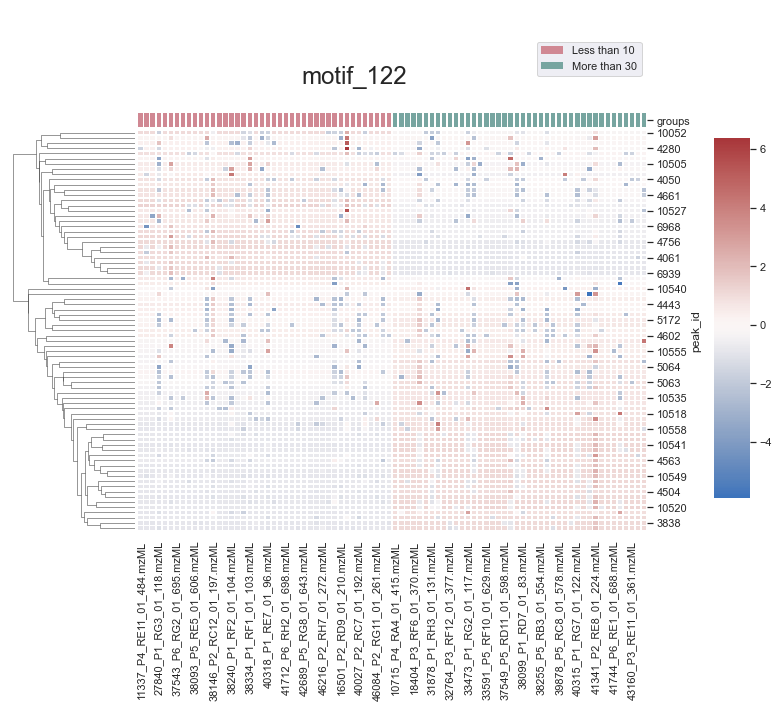

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
3721,NaN,779.8108,7.7096,0.009204,41,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=65&task=0a8432b5891a48d7ad8459ba4a89969f
3735,NaN,763.8089,8.2908,0.012190,38,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=223&task=0a8432b5891a48d7ad8459ba4a89969f
3830,NaN,796.8492,7.6065,0.001765,43,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=65&task=0a8432b5891a48d7ad8459ba4a89969f
3838,NaN,227.2626,4.7612,0.000553,36,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=820&task=0a8432b5891a48d7ad8459ba4a89969f
3866,NaN,227.2698,4.7302,0.000396,37,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=820&task=0a8432b5891a48d7ad8459ba4a89969f
...,...,...,...,...,...,...
10702,NaN,780.8562,8.1836,0.001228,42,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=21&task=0a8432b5891a48d7ad8459ba4a89969f
10704,NaN,939.9559,7.8617,0.000900,35,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=223&task=0a8432b5891a48d7ad8459ba4a89969f
10717,NaN,956.9866,7.8640,0.000412,37,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=21&task=0a8432b5891a48d7ad8459ba4a89969f


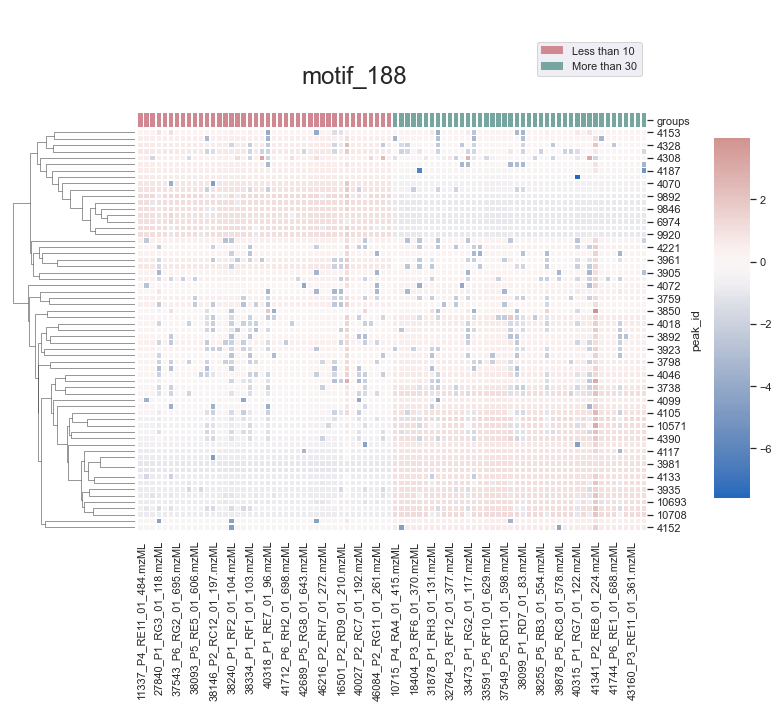

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
3738,NaN,807.8867,8.0880,0.008763,47,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=223&task=0a8432b5891a48d7ad8459ba4a89969f
3759,NaN,791.8889,8.6607,0.010841,40,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=54&task=0a8432b5891a48d7ad8459ba4a89969f
3798,NaN,747.8450,8.7658,0.006608,46,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=54&task=0a8432b5891a48d7ad8459ba4a89969f
3850,NaN,840.9038,7.5153,0.001464,39,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=65&task=0a8432b5891a48d7ad8459ba4a89969f
3858,NaN,824.9181,8.0948,0.002805,46,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=21&task=0a8432b5891a48d7ad8459ba4a89969f
...,...,...,...,...,...,...
10571,NaN,956.0223,7.9446,0.000120,38,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=652&task=0a8432b5891a48d7ad8459ba4a89969f
10693,NaN,763.8335,8.1731,0.000626,32,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=223&task=0a8432b5891a48d7ad8459ba4a89969f
10708,NaN,912.9883,7.9054,0.000680,34,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=21&task=0a8432b5891a48d7ad8459ba4a89969f


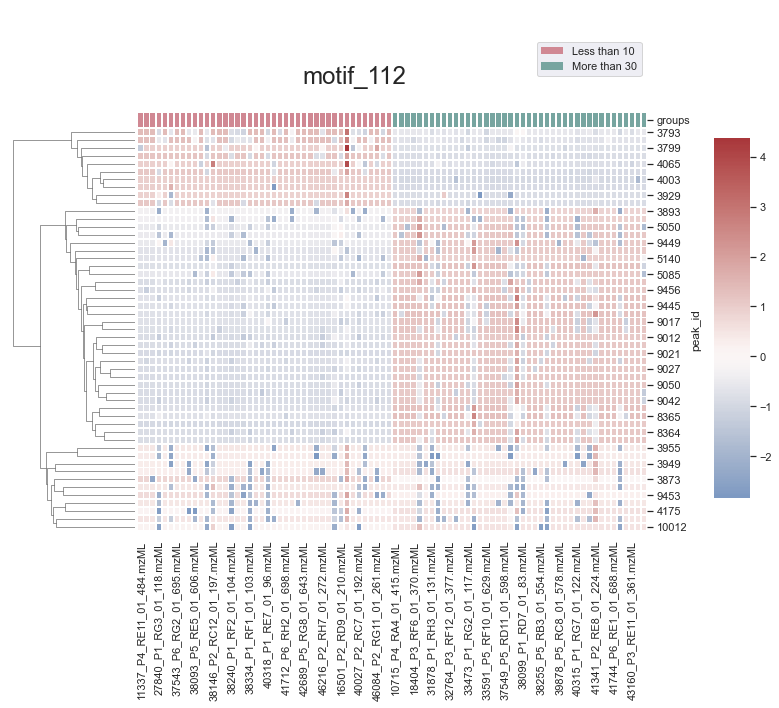

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
3755,NaN,719.7482,8.3015,0.010421,37,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=223&task=0a8432b5891a48d7ad8459ba4a89969f
3775,NaN,598.5550,5.1946,0.001786,71,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=215&task=0a8432b5891a48d7ad8459ba4a89969f
3793,NaN,554.5304,5.2555,0.001443,62,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=215&task=0a8432b5891a48d7ad8459ba4a89969f
3799,NaN,449.4522,5.4823,0.001204,38,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=192&task=0a8432b5891a48d7ad8459ba4a89969f
3829,NaN,675.7094,8.4248,0.004466,41,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=223&task=0a8432b5891a48d7ad8459ba4a89969f
3873,NaN,763.7887,8.2437,0.007288,40,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=223&task=0a8432b5891a48d7ad8459ba4a89969f
3893,NaN,967.9785,8.3714,0.002147,34,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=54&task=0a8432b5891a48d7ad8459ba4a89969f
3929,NaN,466.4810,5.4928,0.000341,17,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=48&task=0a8432b5891a48d7ad8459ba4a89969f
3949,NaN,949.9556,8.4507,0.001635,38,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=480&task=0a8432b5891a48d7ad8459ba4a89969f


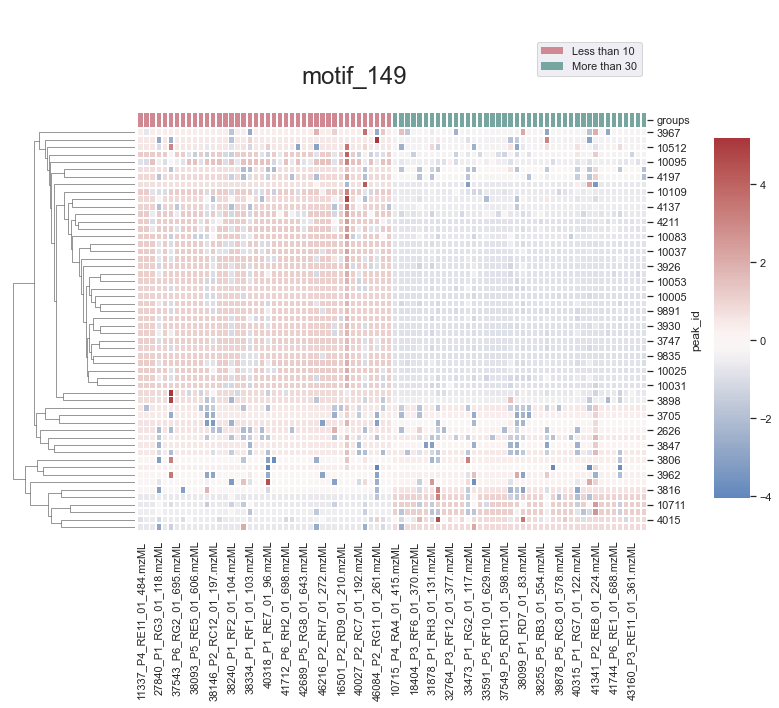

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
2626,NaN,943.9980,8.0909,0.000815,49,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1807&task=0a8432b5891a48d7ad8459ba4a89969f
3705,NaN,725.8276,6.5950,0.032219,39,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=530&task=0a8432b5891a48d7ad8459ba4a89969f
3709,NaN,769.8630,6.5482,0.023806,50,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=530&task=0a8432b5891a48d7ad8459ba4a89969f
3726,NaN,735.8221,7.6932,0.004858,30,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=65&task=0a8432b5891a48d7ad8459ba4a89969f
3747,NaN,691.7863,7.8109,0.006865,38,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=65&task=0a8432b5891a48d7ad8459ba4a89969f
3784,NaN,896.0010,7.9015,0.002197,38,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=223&task=0a8432b5891a48d7ad8459ba4a89969f
3794,NaN,647.7356,7.9220,0.006818,30,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=65&task=0a8432b5891a48d7ad8459ba4a89969f
3806,NaN,911.9857,7.3512,0.001966,28,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=65&task=0a8432b5891a48d7ad8459ba4a89969f
3808,NaN,663.7398,7.3026,0.001831,47,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=590&task=0a8432b5891a48d7ad8459ba4a89969f


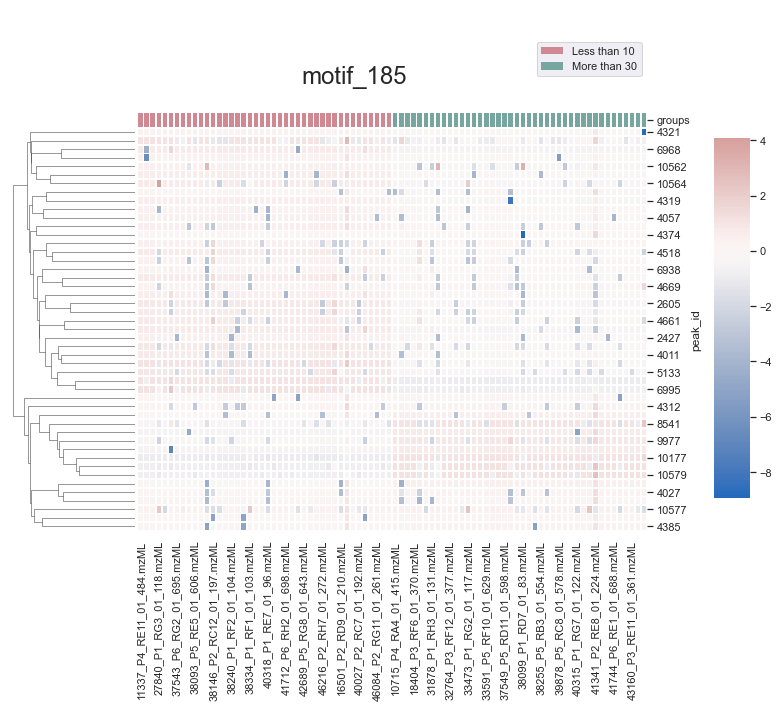

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
2427,NaN,941.9889,10.0339,0.007078,22,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1439&task=0a8432b5891a48d7ad8459ba4a89969f
2438,NaN,920.0013,10.0391,0.004572,31,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=528&task=0a8432b5891a48d7ad8459ba4a89969f
2479,NaN,937.0327,10.0495,0.001711,18,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=279&task=0a8432b5891a48d7ad8459ba4a89969f
2605,NaN,941.9894,8.2164,0.013642,41,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1439&task=0a8432b5891a48d7ad8459ba4a89969f
2609,NaN,920.0019,8.2465,0.002859,33,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=528&task=0a8432b5891a48d7ad8459ba4a89969f
2610,NaN,937.0335,8.2110,0.001251,38,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=279&task=0a8432b5891a48d7ad8459ba4a89969f
2614,NaN,937.0331,8.3959,0.001838,36,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=279&task=0a8432b5891a48d7ad8459ba4a89969f
4001,NaN,859.9626,10.0235,0.002199,16,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=806&task=0a8432b5891a48d7ad8459ba4a89969f
4011,NaN,937.0325,12.0036,0.002717,15,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=279&task=0a8432b5891a48d7ad8459ba4a89969f


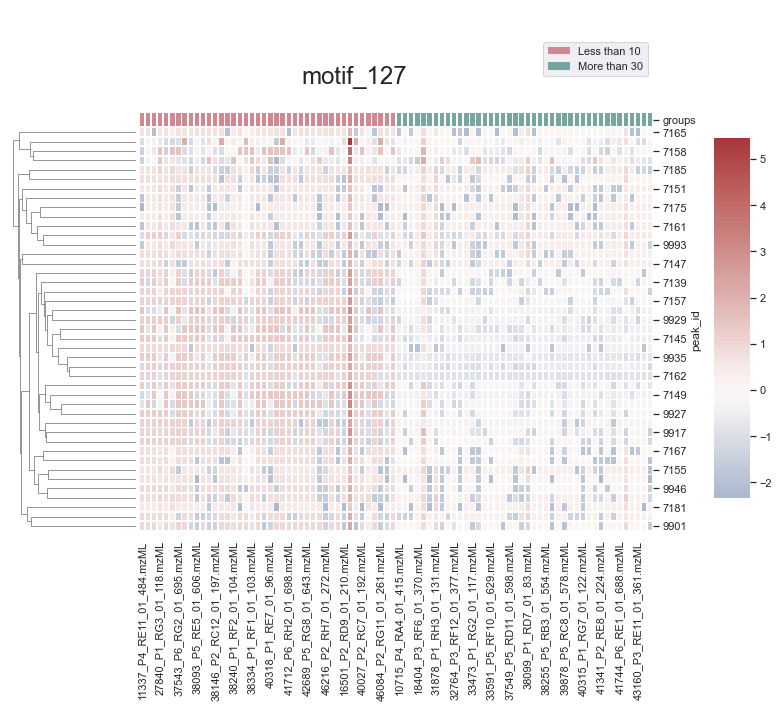

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
7138,NaN,582.6597,2.8030,0.000904,83,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=781&task=0a8432b5891a48d7ad8459ba4a89969f
7139,NaN,604.6841,2.8091,0.000915,81,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=781&task=0a8432b5891a48d7ad8459ba4a89969f
7140,NaN,560.6346,2.7715,0.003000,106,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=781&task=0a8432b5891a48d7ad8459ba4a89969f
7141,NaN,538.6105,2.7542,0.003149,79,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=781&task=0a8432b5891a48d7ad8459ba4a89969f
7142,NaN,626.7083,2.8047,0.001632,83,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=781&task=0a8432b5891a48d7ad8459ba4a89969f
7143,NaN,516.5857,2.7515,0.003144,75,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=781&task=0a8432b5891a48d7ad8459ba4a89969f
7144,NaN,670.7575,2.8144,0.000695,64,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=781&task=0a8432b5891a48d7ad8459ba4a89969f
7145,NaN,648.7330,2.8164,0.001067,73,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=781&task=0a8432b5891a48d7ad8459ba4a89969f
7147,NaN,494.5610,2.7598,0.002796,77,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=781&task=0a8432b5891a48d7ad8459ba4a89969f


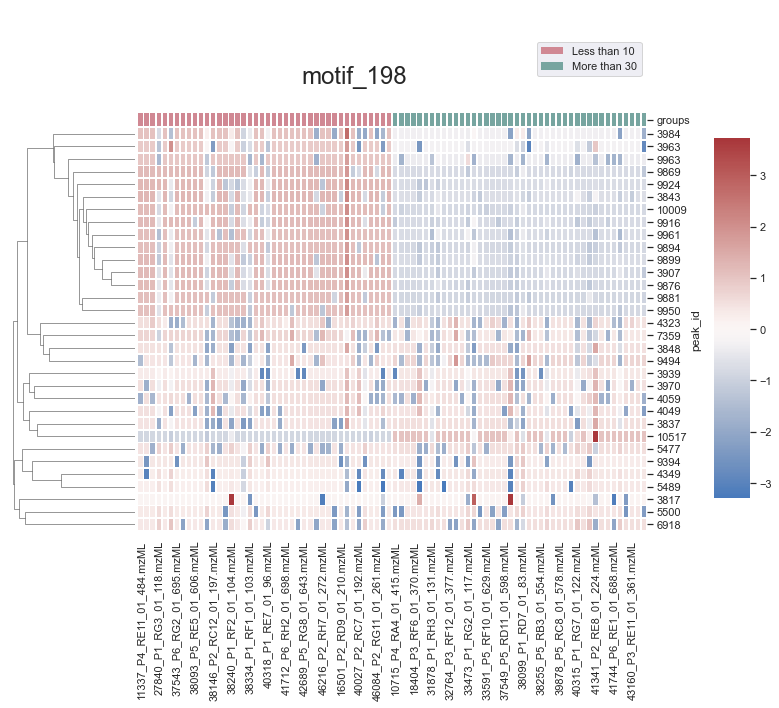

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
3817,NaN,751.8591,7.1249,0.002048,36,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=590&task=0a8432b5891a48d7ad8459ba4a89969f
3837,NaN,679.7860,6.7127,0.003670,57,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=223&task=0a8432b5891a48d7ad8459ba4a89969f
3843,NaN,795.9237,6.9916,0.002949,59,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=590&task=0a8432b5891a48d7ad8459ba4a89969f
3848,NaN,635.7509,6.7925,0.004568,54,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=223&task=0a8432b5891a48d7ad8459ba4a89969f
3907,NaN,812.9570,7.0064,0.002116,43,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=21&task=0a8432b5891a48d7ad8459ba4a89969f
3939,NaN,855.9723,6.4719,0.004283,56,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=223&task=0a8432b5891a48d7ad8459ba4a89969f
3963,NaN,591.7055,6.9704,0.001107,44,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=223&task=0a8432b5891a48d7ad8459ba4a89969f
3970,NaN,873.0055,6.4743,0.003346,72,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=21&task=0a8432b5891a48d7ad8459ba4a89969f
3984,NaN,547.6543,7.0357,0.000742,47,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=223&task=0a8432b5891a48d7ad8459ba4a89969f


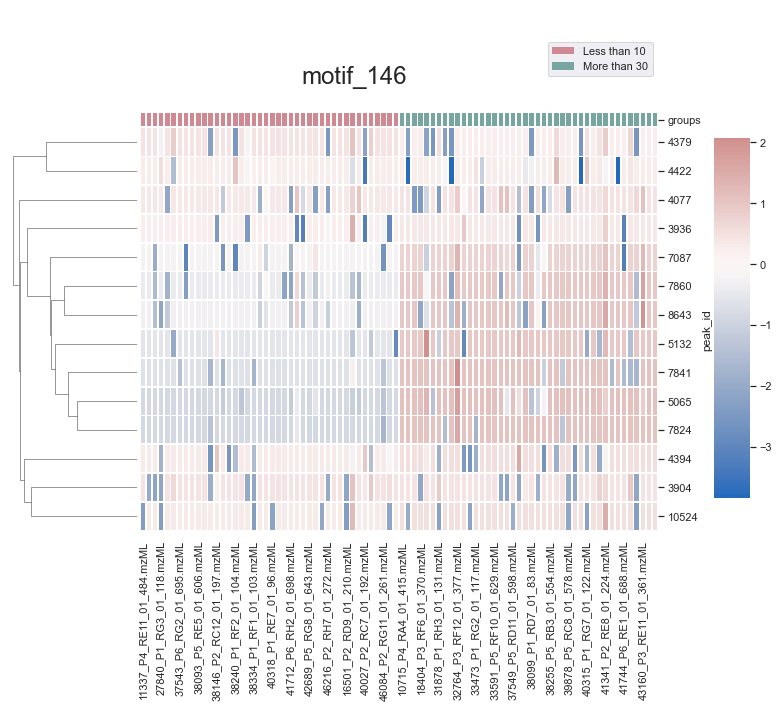

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
3904,NaN,283.3850,6.6902,0.005757,62,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=107&task=0a8432b5891a48d7ad8459ba4a89969f
3936,NaN,281.3685,6.1956,0.003249,32,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=107&task=0a8432b5891a48d7ad8459ba4a89969f
4077,NaN,282.4009,5.9633,0.006391,72,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=107&task=0a8432b5891a48d7ad8459ba4a89969f
4379,NaN,283.3875,6.8500,0.003451,41,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=107&task=0a8432b5891a48d7ad8459ba4a89969f
4394,NaN,311.4286,6.4895,0.003489,45,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=107&task=0a8432b5891a48d7ad8459ba4a89969f
4422,NaN,283.3847,7.0033,0.005851,42,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=107&task=0a8432b5891a48d7ad8459ba4a89969f
5065,NaN,323.4336,5.9353,0.002334,52,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=643&task=0a8432b5891a48d7ad8459ba4a89969f
5132,NaN,381.4641,6.3418,0.000442,24,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=643&task=0a8432b5891a48d7ad8459ba4a89969f
7087,NaN,303.3992,5.9393,0.017853,55,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=643&task=0a8432b5891a48d7ad8459ba4a89969f


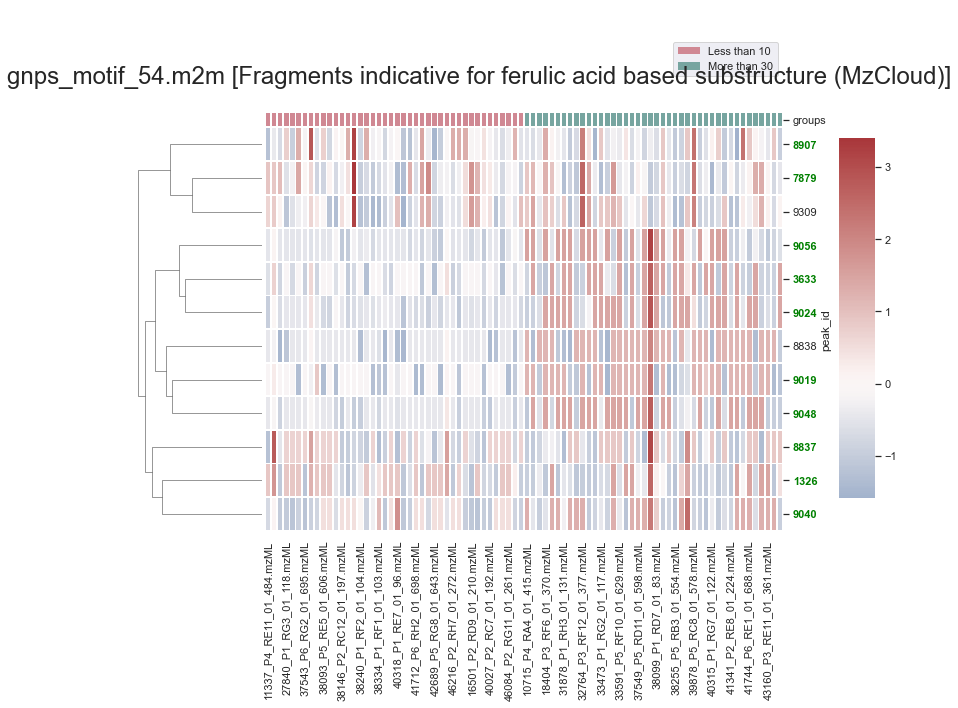

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
1326,Spectral Match to Curcumin from NIST14,369.1335,4.0253,0.032184,145,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=127&task=0a8432b5891a48d7ad8459ba4a89969f
3633,Spectral Match to Curcumin from NIST14,369.1336,3.1547,0.002445,97,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=127&task=0a8432b5891a48d7ad8459ba4a89969f
7879,Spectral Match to 3-Hydroxy-4-methoxycinnamic acid from NIST14,195.0655,2.4750,0.001998,192,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=127&task=0a8432b5891a48d7ad8459ba4a89969f
8837,Spectral Match to 3-Hydroxy-4-methoxycinnamic acid from NIST14,177.0538,4.0199,0.000481,127,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=127&task=0a8432b5891a48d7ad8459ba4a89969f
8838,NaN,371.1490,3.8366,0.004556,49,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=127&task=0a8432b5891a48d7ad8459ba4a89969f
8907,MoNA:3697220 Feruloyltyramine,265.1549,0.8890,0.001524,177,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=127&task=0a8432b5891a48d7ad8459ba4a89969f
9019,"NCGC00095321-06!(1E,4Z,6E)-5-hydroxy-1,7-bis(4-hydroxy-3-methoxyphenyl)hepta-1,4,6-trien-3-one",369.1332,4.2750,0.001551,85,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=127&task=0a8432b5891a48d7ad8459ba4a89969f
9024,"(1R,3R,4S,5R)-1,3,4-trihydroxy-5-[(E)-3-(4-hydroxyphenyl)prop-2-enoyl]oxycyclohexane-1-carboxylic acid",339.1230,3.1470,0.000508,103,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=127&task=0a8432b5891a48d7ad8459ba4a89969f
9040,Spectral Match to Curcumin from NIST14,369.1331,3.8770,0.003096,128,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=127&task=0a8432b5891a48d7ad8459ba4a89969f


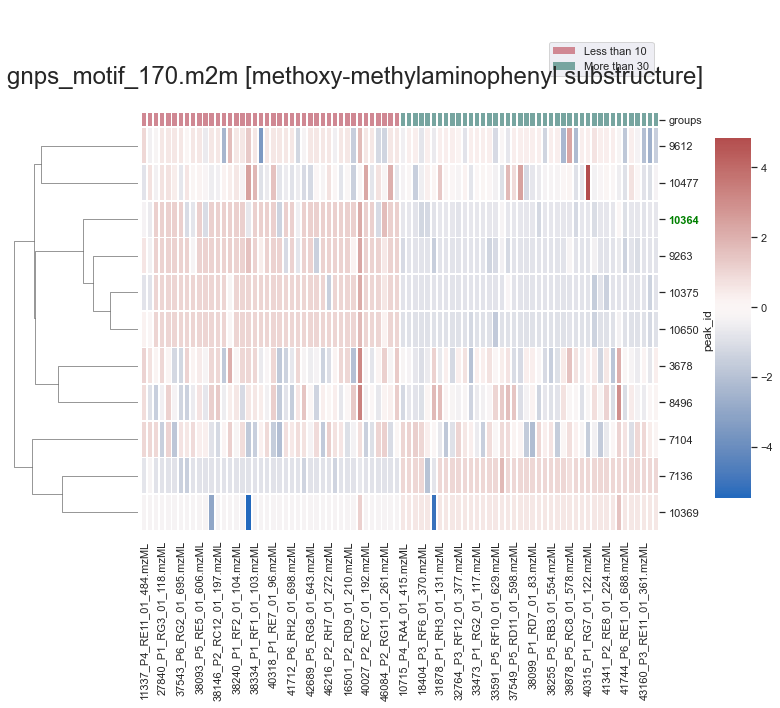

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
3678,NaN,399.3253,5.7595,0.000823,159,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=148&task=0a8432b5891a48d7ad8459ba4a89969f
7104,NaN,353.2691,4.9069,0.009178,197,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=409&task=0a8432b5891a48d7ad8459ba4a89969f
7136,NaN,343.2255,3.2039,0.000161,25,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=148&task=0a8432b5891a48d7ad8459ba4a89969f
8496,NaN,383.3314,8.3489,0.007551,196,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=148&task=0a8432b5891a48d7ad8459ba4a89969f
9263,NaN,369.2410,4.2581,0.000547,56,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=148&task=0a8432b5891a48d7ad8459ba4a89969f
9612,NaN,371.2578,4.3831,0.008217,90,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=148&task=0a8432b5891a48d7ad8459ba4a89969f
10364,Spectral Match to Boldione from NIST14,285.1853,3.1896,0.000941,52,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=148&task=0a8432b5891a48d7ad8459ba4a89969f
10369,NaN,413.3041,5.2675,0.000591,16,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=148&task=0a8432b5891a48d7ad8459ba4a89969f
10375,NaN,313.2165,3.7372,0.000360,28,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=148&task=0a8432b5891a48d7ad8459ba4a89969f


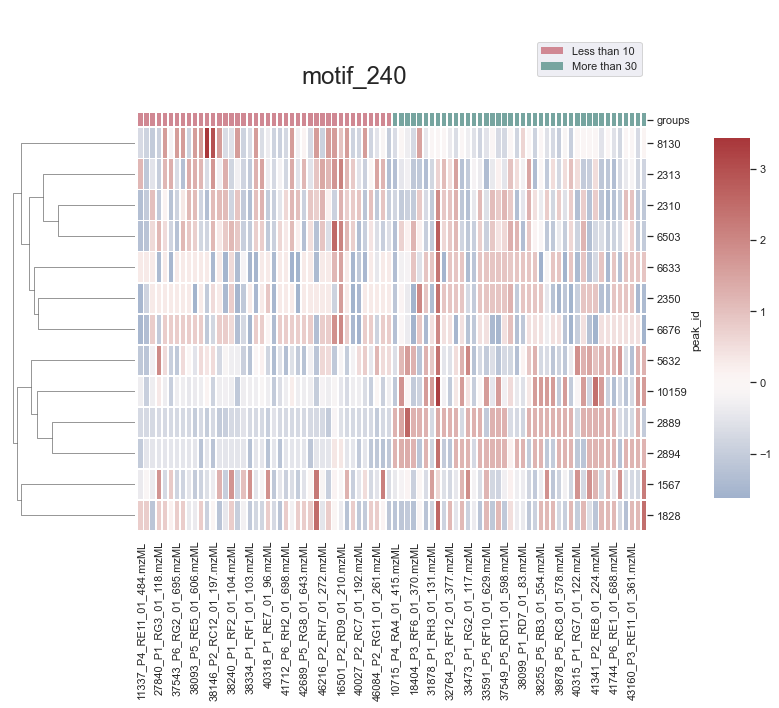

,LibraryID,Precursor m/z,RTConsensus,PrecursorInt,no_spectra,link
id,,,,,,
1567,NaN,941.7275,8.9466,0.009000,184,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=2816&task=0a8432b5891a48d7ad8459ba4a89969f
1828,NaN,936.7710,8.9779,0.001843,126,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=250&task=0a8432b5891a48d7ad8459ba4a89969f
2310,NaN,941.7276,8.1077,0.012113,187,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=995&task=0a8432b5891a48d7ad8459ba4a89969f
2313,NaN,941.7265,8.2215,0.016109,171,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=995&task=0a8432b5891a48d7ad8459ba4a89969f
2350,NaN,936.7716,7.9662,0.000950,98,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=250&task=0a8432b5891a48d7ad8459ba4a89969f
2889,NaN,941.7274,6.7304,0.000170,72,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1514&task=0a8432b5891a48d7ad8459ba4a89969f
2894,NaN,941.7274,6.9939,0.000382,72,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1514&task=0a8432b5891a48d7ad8459ba4a89969f
5632,NaN,936.7709,10.0343,0.002338,146,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=250&task=0a8432b5891a48d7ad8459ba4a89969f
6503,NaN,941.7278,7.6249,0.005232,170,https://gnps.ucsd.edu/ProteoSAFe/result.jsp?view=network_displayer&componentindex=1708&task=0a8432b5891a48d7ad8459ba4a89969f


In [29]:
for idx, row in df.iterrows():
    members = gnps_ds.dataset_pathways_to_row_ids[idx]
    if len(members) < min_members:
        continue
        
    pw_name = row['pw_name']
    p_value = row[p_value_col]
                
    # get group intensities
    group_intensities = intensities_df.loc[members][all_samples]    
    
    # get group info
    # print('%s p-value=%.4f' % (pw_name, p_value))
    data = []
    for member in members:
        member_info = entity_dict[member]
        unique_id = member_info['unique_id']
        library_id = member_info['LibraryID']
        gnps_linkout_network = member_info['GNPSLinkout_Network']
        no_spectra = member_info['number of spectra']
        rt = member_info['RT']
        mz = member_info['mass']    
        intensity = member_info['SumPeakIntensity']
        row = [unique_id, library_id, mz, rt, intensity, no_spectra, gnps_linkout_network]
        data.append(row)
    member_df = pd.DataFrame(data, columns=['id', 'LibraryID', 'Precursor m/z', 'RTConsensus', 'PrecursorInt', 'no_spectra', 'link']).set_index('id')    
    
    # Create a categorical palette to identify the networks
    used_groups = list(set(all_groups))
    group_pal = sns.husl_palette(len(used_groups), s=.45)
    group_lut = dict(zip(map(str, used_groups), group_pal))

    # Convert the palette to vectors that will be drawn on the side of the matrix
    group_colours = pd.Series(all_groups, index=group_intensities.columns).map(group_lut)    
    group_colours.name = 'groups'
    
    # plot heatmap
    g = sns.clustermap(group_intensities, center=0, cmap=cmap, col_colors=group_colours, 
                   col_cluster=False, linewidths=0.75, figsize=(10, 10), cbar_pos=(1.0, 0.3, 0.05, 0.5))
    plt.suptitle('%s' % (pw_name), fontsize=24, y=0.9)

    # draw group legend
    for group in used_groups:
        g.ax_col_dendrogram.bar(0, 0, color=group_lut[group], label=group, linewidth=0)
    g.ax_col_dendrogram.legend(loc="right")
    
    # make the annotated peaks to have labels in bold
    annotated_df = member_df[member_df['LibraryID'].notnull()]
    annotated_peaks = annotated_df.index.values
    for label in g.ax_heatmap.get_yticklabels():
        if label.get_text() in annotated_peaks:
            label.set_weight("bold")
            label.set_color("green")   
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)        

    plt.show()
    display(member_df)